
# EmotionRecognitionCNN.ipynb

This notebook:
1. Load `data/cls_pool/`, create a **seeded stratified** split into `data/cls_data/` (one time).
2. Define **BASELINE CONFIG** and train/evaluate (frozen).
3. Define a reusable **run_experiment(config, tag)** that:
  - builds model
  - trains with callbacks
  - evaluates (val/test, F1, confusion)
  - logs to `artifacts/trials/<run_id>/` and updates `artifacts/outputs/leaderboard.csv`
4. Define optimization framework for experimentation: **optimizations only** (override config keys), compare in leaderboard/plots.



## Setup Imports, fixed seed, paths


In [2]:
import sys, os, platform, json, math, time, uuid, csv, shutil, random, sklearn
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import tqdm as tq
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as pb
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import itertools
import io

print("Python:", sys.version)
print("OS:", platform.platform())
print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)
print("scikit-learn:", sklearn.__version__)
print("tqdm:", tq.__version__)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paths
DATA = Path("../data")
POOL = DATA / "cls_pool"       # prepeared dataset pool
CLS  = DATA / "cls_data"       # split written here
ART  = Path("../artifacts")
MODELS = ART / "models"
TRIALS = ART / "trials"
OUTS   = ART / "outputs"
for p in [CLS, MODELS, TRIALS, OUTS]: p.mkdir(parents=True, exist_ok=True)

# Class names
with open(OUTS / "class_names.json", "r") as f:
    CLASS_NAMES = json.load(f)
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)


Python: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
OS: Windows-11-10.0.26200-SP0
NumPy: 2.2.6
TensorFlow: 2.20.0
scikit-learn: 1.6.1
tqdm: 4.67.1
Classes: ['Angry', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Sleepy', 'Surprised']


## Create a seeded, stratified split (70/15/15) **once**, save manifest


In [3]:
# Collect pool paths & labels
X, y = [], []
for i, cname in enumerate(sorted(CLASS_NAMES)):
    for p in (POOL / cname).glob("*"):
        if p.suffix.lower() in {".jpg",".jpeg",".png"}:
            X.append(p); y.append(cname)
X = np.array(X); y = np.array(y)

# If a previous split manifest exists, reuse it (keeps trials comparable)
split_manifest_path = OUTS / "split_manifest.json"
if split_manifest_path.exists():
    with open(split_manifest_path, "r") as f:
        split_manifest = json.load(f)
    print("Loaded existing split manifest.")
else:
    # 70/30, then split the 30 into 15/15
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
    (train_idx, temp_idx) = next(sss1.split(X, y))
    X_train, y_train = X[train_idx], y[train_idx]
    X_temp,  y_temp  = X[temp_idx],  y[temp_idx]

    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
    (val_idx, test_idx) = next(sss2.split(X_temp, y_temp))
    X_val, y_val   = X_temp[val_idx],  y_temp[val_idx]
    X_test, y_test = X_temp[test_idx], y_temp[test_idx]

    # Write files into cls_data/<split>/<class> (idempotent)
    def place(paths, labels, split):
        print(f"Copying {len(paths)} files to {split}/ ...")
        for p, lbl in pb(zip(paths, labels), total=len(paths), desc=f"{split:>5s} split"):
            dst = CLS / split / lbl
            dst.mkdir(parents=True, exist_ok=True)
            shutil.copy2(p, dst / p.name)
    place(X_train, y_train, "train")
    place(X_val,   y_val,   "val")
    place(X_test,  y_test,  "test")

    split_manifest = {
        "seed": SEED,
        "splits": {
            "train": [str((CLS / "train" / y_train[i] / X_train[i].name).resolve()) for i in range(len(X_train))],
            "val":   [str((CLS / "val"   / y_val[i]   / X_val[i].name).resolve())   for i in range(len(X_val))],
            "test":  [str((CLS / "test"  / y_test[i]  / X_test[i].name).resolve())  for i in range(len(X_test))]
        }
    }
    with open(split_manifest_path, "w") as f:
        json.dump(split_manifest, f, indent=2)
    print("Created split and saved manifest:", split_manifest_path)

# Keras datasets
IMG = 96; BATCH = 64
def make_ds(split):
    return tf.keras.preprocessing.image_dataset_from_directory(
        CLS / split,
        labels="inferred", label_mode="int",
        color_mode="grayscale", image_size=(IMG, IMG),
        batch_size=BATCH, shuffle=True, seed=SEED)
train_ds = make_ds("train"); val_ds = make_ds("val"); test_ds = make_ds("test")
class_names = train_ds.class_names
assert class_names == CLASS_NAMES, (class_names, CLASS_NAMES)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Loaded existing split manifest.
Found 47540 files belonging to 9 classes.
Found 10187 files belonging to 9 classes.
Found 10188 files belonging to 9 classes.


## Define **Baseline configuration**

This cell will remain unchanged. All future optimizations will override keys in later defined cells.


In [4]:
BASELINE = {
    "img_size": IMG,
    "batch_size": BATCH,
    "epochs": 60,
    "optimizer": "adam",
    "learning_rate": 1e-3,
    "l2": 1e-4,
    "dropout": 0.4,
    "augment": {"flip": True, "rotation": 0.08, "zoom": 0.10},
    "filters": [32, 64, 128, 256],
    "use_residual": True,
    "seed": SEED,
}
print(json.dumps(BASELINE, indent=2))


{
  "img_size": 96,
  "batch_size": 64,
  "epochs": 60,
  "optimizer": "adam",
  "learning_rate": 0.001,
  "l2": 0.0001,
  "dropout": 0.4,
  "augment": {
    "flip": true,
    "rotation": 0.08,
    "zoom": 0.1
  },
  "filters": [
    32,
    64,
    128,
    256
  ],
  "use_residual": true,
  "seed": 42
}


## Define model builder utility and **run_experiment(config, tag)**

This utility will provide the following functionality:
- builds the CNN from `config`
- trains with EarlyStopping + ReduceLROnPlateau
- evaluates on **val** and **test**
- logs everything to `artifacts/trials/<run_id>/` and updates `artifacts/outputs/leaderboard.csv`


In [5]:
def conv_block(x, f, k=3, pool=True, l2=1e-4):
    x = layers.Conv2D(f, k, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if pool: x = layers.MaxPool2D()(x)
    return x

def residual_stack(x, f, l2=1e-4):
    sc = layers.Conv2D(f, 1, padding="same", use_bias=False,
                       kernel_regularizer=regularizers.l2(l2))(x)
    sc = layers.BatchNormalization()(sc)
    y = layers.Conv2D(f, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(x)
    y = layers.BatchNormalization()(y); y = layers.ReLU()(y)
    y = layers.Conv2D(f, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(l2))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Add()([y, sc]); y = layers.ReLU()(y)
    y = layers.MaxPool2D()(y)
    return y

def build_model(cfg):
    tf.random.set_seed(cfg["seed"])
    augment_layers = []
    if cfg["augment"].get("flip"):     augment_layers.append(layers.RandomFlip("horizontal"))
    if cfg["augment"].get("rotation"): augment_layers.append(layers.RandomRotation(cfg["augment"]["rotation"]))
    if cfg["augment"].get("zoom"):     augment_layers.append(layers.RandomZoom(cfg["augment"]["zoom"]))
    augment = tf.keras.Sequential(augment_layers)

    inp = layers.Input((cfg["img_size"], cfg["img_size"], 1))
    x = augment(inp)
    x = layers.Rescaling(1./255)(x)

    f1, f2, f3, f4 = cfg["filters"]
    x = conv_block(x, f1, l2=cfg["l2"])
    x = conv_block(x, f2, l2=cfg["l2"])
    if cfg["use_residual"]:
        x = residual_stack(x, f3, l2=cfg["l2"])
    else:
        x = conv_block(x, f3, l2=cfg["l2"])
        x = layers.MaxPool2D()(x)

    x = conv_block(x, f4, pool=False, l2=cfg["l2"])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(cfg["dropout"])(x)
    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = models.Model(inp, out)

    opt = tf.keras.optimizers.Adam(cfg["learning_rate"]) if cfg["optimizer"] == "adam" else tf.keras.optimizers.SGD(cfg["learning_rate"], momentum=0.9, nesterov=True)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def compute_class_weights(ds):
    # count labels from train_ds
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)
    for _, yb in tf.data.Dataset.unbatch(ds.take(999999)):
        counts[int(yb.numpy())] += 1
    total = counts.sum()
    return {i: float(total/(NUM_CLASSES*counts[i])) for i in range(NUM_CLASSES)}

LEADERBOARD = OUTS / "leaderboard.csv"
if not LEADERBOARD.exists():
    with open(LEADERBOARD, "w", newline="") as f:
        csv.writer(f).writerow(["run_id","tag","val_acc","val_f1_macro","test_acc","test_f1_macro","epochs","params_json"])

def plot_accuracy(history, out_png_path, show=True):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(6,4))
    if "accuracy" in h:      plt.plot(epochs, h["accuracy"], label="train")
    if "val_accuracy" in h:  plt.plot(epochs, h["val_accuracy"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_png_path, dpi=160)
    if show: plt.show()
    plt.close()

def plot_loss(history, out_png_path, show=True):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, h["loss"], label="train")
    if "val_loss" in h: plt.plot(epochs, h["val_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_png_path, dpi=160)
    if show: plt.show()
    plt.close()

def plot_confusion(cm, class_names, out_png_path, normalize=True, cmap="Blues", show=True):
    """Friendly confusion matrix; saves to file and (optionally) shows inline."""
    if normalize:
        with np.errstate(all="ignore"):
            cmn = cm.astype("float") / cm.sum(axis=1, keepdims=True)
            cmn = np.nan_to_num(cmn)
    else:
        cmn = cm

    plt.figure(figsize=(8,6))
    plt.imshow(cmn, interpolation="nearest", cmap=cmap)
    plt.title("Confusion Matrix" + (" (normalized)" if normalize else ""))
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    thresh = cmn.max() / 2.0
    for i, j in itertools.product(range(cmn.shape[0]), range(cmn.shape[1])):
        val = cmn[i, j] if normalize else cm[i, j]
        txt_color = "white" if cmn[i, j] > thresh else "black"
        plt.text(j, i, f"{val:.2f}" if normalize else f"{val}",
                 ha="center", va="center", color=txt_color, fontsize=9)

    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(out_png_path, dpi=160)
    if show: plt.show()
    plt.close()

def save_model_summary(model, out_txt_path):
    buff = io.StringIO()
    model.summary(print_fn=lambda s: buff.write(s + "\n"))  # capture
    summary_txt = buff.getvalue()
    with open(out_txt_path, "w", encoding="utf-8") as f:
        f.write(summary_txt)

def run_experiment(cfg, tag="baseline"):
    run_id = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "_" + tag
    run_dir = TRIALS / run_id
    run_dir.mkdir(parents=True, exist_ok=True)

    # freeze params used
    with open(run_dir / "params.json", "w") as f:
        json.dump(cfg, f, indent=2)

    model = build_model(cfg)

    # save model summary
    save_model_summary(model, run_dir / "model_summary.txt")

    cbs = [
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5),
        tf.keras.callbacks.ModelCheckpoint(str(run_dir / "model.keras"), monitor="val_accuracy", save_best_only=True),
    ]
    class_weight = compute_class_weights(train_ds)

    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg["epochs"],
        class_weight=class_weight,
        callbacks=cbs,
        verbose=1
    )

    # show + save accuracy & loss plots
    plot_accuracy(hist, run_dir / "accuracy.png", show=True)
    plot_loss(hist,     run_dir / "loss.png",     show=True)

    # Save history json
    with open(run_dir / "history.json", "w") as f:
        json.dump({k: [float(x) for x in v] for k, v in hist.history.items()}, f, indent=2)

    # Evaluate
    val_metrics = model.evaluate(val_ds, verbose=0)
    test_metrics = model.evaluate(test_ds, verbose=0)

    # Detailed predictions for test set
    y_true, y_pred = [], []
    for xb, yb in tf.data.Dataset.unbatch(test_ds):
        probs = model.predict(tf.expand_dims(xb, 0), verbose=0)[0]
        y_true.append(int(yb.numpy()))
        y_pred.append(int(np.argmax(probs)))

    test_f1_macro = float(f1_score(y_true, y_pred, average="macro"))

    # Classification report (save file; also print short summary)
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print("\nClassification report (test):\n", report)
    with open(run_dir / "classification_report.txt", "w", encoding="utf-8") as f:
        f.write(report)

    # save + show Confusion matrices: raw & normalized
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion(cm, CLASS_NAMES, run_dir / "confusion_matrix_raw.png", normalize=False, cmap="Blues", show=True)
    plot_confusion(cm, CLASS_NAMES, run_dir / "confusion_matrix_norm.png", normalize=True,  cmap="Blues", show=True)

    # Summaries
    val_acc  = float(val_metrics[1])
    test_acc = float(test_metrics[1])
    metrics = {
        "val_accuracy": val_acc,
        "test_accuracy": test_acc,
        "test_f1_macro": test_f1_macro,
        "epochs_trained": int(len(hist.history["loss"]))
    }
    with open(run_dir / "metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    # Leaderboard row
    with open(LEADERBOARD, "a", newline="") as f:
        csv.writer(f).writerow([
            run_id, tag,
            f"{val_acc:.4f}",
            f"{float(f1_score(y_true, y_pred, average='macro')):.4f}",
            f"{test_acc:.4f}",
            f"{test_f1_macro:.4f}",
            metrics["epochs_trained"],
            json.dumps(cfg)
        ])

    print("Saved trial to:", run_dir)
    return run_id, metrics



## Run baseline


Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 226s 301ms/step - accuracy: 0.1874 - loss: 2.0909 - val_accuracy: 0.2727 - val_loss: 1.9744 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 219s 295ms/step - accuracy: 0.3028 - loss: 1.7993 - val_accuracy: 0.3189 - val_loss: 1.8332 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 216s 291ms/step - accuracy: 0.3778 - loss: 1.6206 - val_accuracy: 0.4732 - val_loss: 1.5188 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 218s 293ms/step - accuracy: 0.4327 - loss: 1.5092 - val_accuracy: 0.4045 - val_loss: 1.7018 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 218s 293ms/step - accuracy: 0.4752 - loss: 1.4180 - val_accuracy: 0.4360 - val_loss: 1.6568 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 218s 293ms/step - accuracy: 0.5011 - loss: 1.3540 - val_accuracy: 0.4074 - val_loss: 1.7856 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 218s 294ms/step - accura

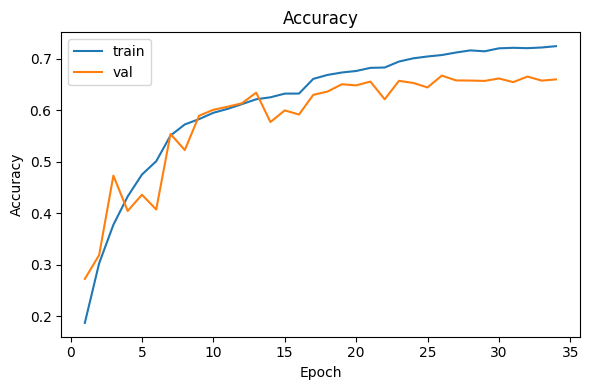

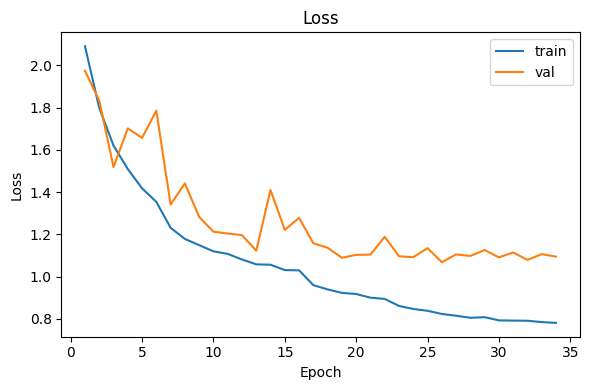


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.63      0.67      0.65      1755
    Contempt       0.39      0.71      0.51       404
     Disgust       0.42      0.70      0.53       675
        Fear       0.61      0.73      0.67       813
       Happy       0.94      0.65      0.77      2188
     Neutral       0.50      0.53      0.51       895
         Sad       0.74      0.54      0.63      1882
      Sleepy       0.81      0.87      0.84       168
   Surprised       0.70      0.73      0.71      1408

    accuracy                           0.65     10188
   macro avg       0.64      0.68      0.65     10188
weighted avg       0.69      0.65      0.66     10188



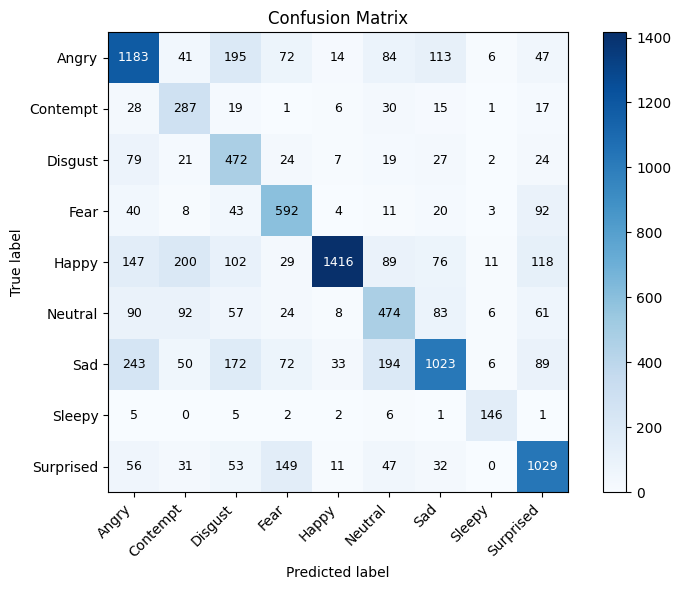

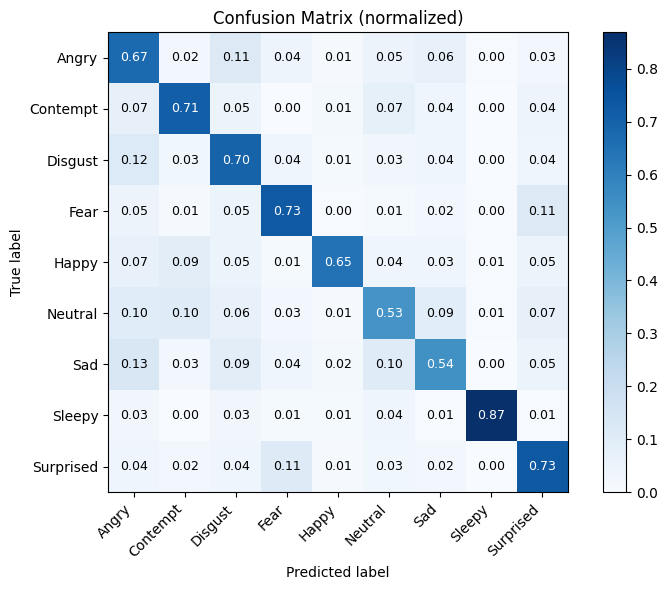

Saved trial to: ..\artifacts\trials\2025-11-18_06-36-05_baseline


{'val_accuracy': 0.6672229170799255,
 'test_accuracy': 0.649980366230011,
 'test_f1_macro': 0.6451742236379785,
 'epochs_trained': 34}

In [5]:
# Make a copy so later optimizations won't recast BASELINE
baseline_cfg = json.loads(json.dumps(BASELINE))
run_id, metrics = run_experiment(baseline_cfg, tag="baseline")
metrics


## Run optimization: Learning Rate Reduction

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 218s 291ms/step - accuracy: 0.1989 - loss: 2.0801 - val_accuracy: 0.1836 - val_loss: 2.1845 - learning_rate: 2.5000e-04
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 217s 292ms/step - accuracy: 0.2950 - loss: 1.8260 - val_accuracy: 0.2559 - val_loss: 2.0426 - learning_rate: 2.5000e-04
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 217s 292ms/step - accuracy: 0.3526 - loss: 1.6714 - val_accuracy: 0.3850 - val_loss: 1.7262 - learning_rate: 2.5000e-04
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 217s 292ms/step - accuracy: 0.3976 - loss: 1.5630 - val_accuracy: 0.3152 - val_loss: 1.8608 - learning_rate: 2.5000e-04
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 217s 292ms/step - accuracy: 0.4320 - loss: 1.4820 - val_accuracy: 0.4186 - val_loss: 1.6770 - learning_rate: 2.5000e-04
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 217s 292ms/step - accuracy: 0.4572 - loss: 1.4270 - val_accuracy: 0.4462 - val_loss: 1.5369 - learning_rate: 2.5000e-04
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 

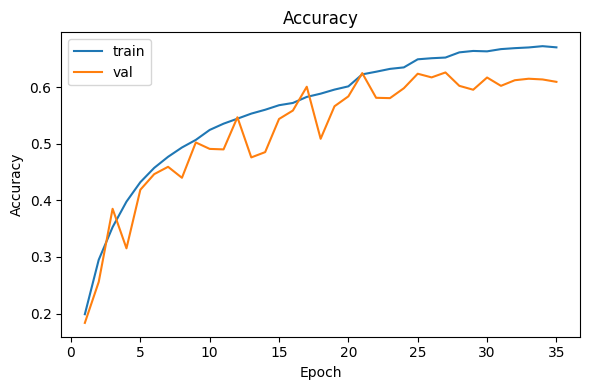

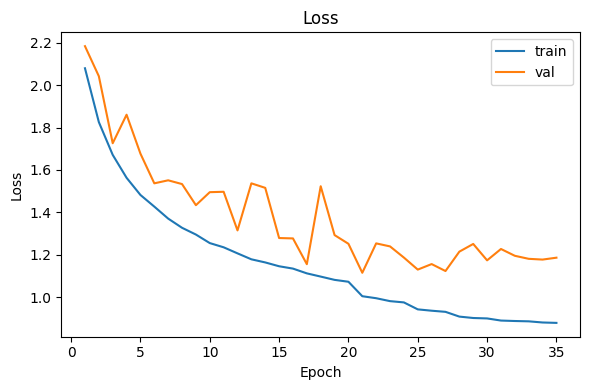


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.53      0.70      0.60      1755
    Contempt       0.42      0.56      0.48       404
     Disgust       0.66      0.50      0.57       675
        Fear       0.48      0.74      0.58       813
       Happy       0.88      0.67      0.76      2188
     Neutral       0.47      0.50      0.48       895
         Sad       0.71      0.43      0.54      1882
      Sleepy       0.70      0.83      0.76       168
   Surprised       0.63      0.70      0.66      1408

    accuracy                           0.61     10188
   macro avg       0.61      0.63      0.60     10188
weighted avg       0.65      0.61      0.62     10188



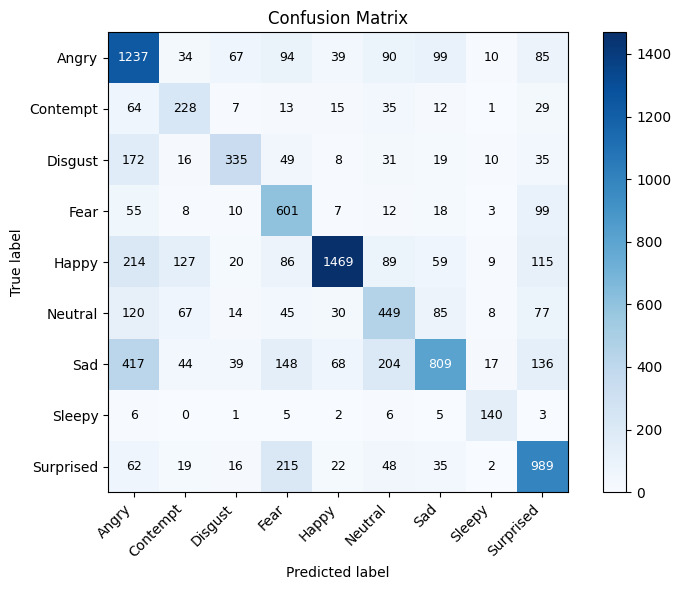

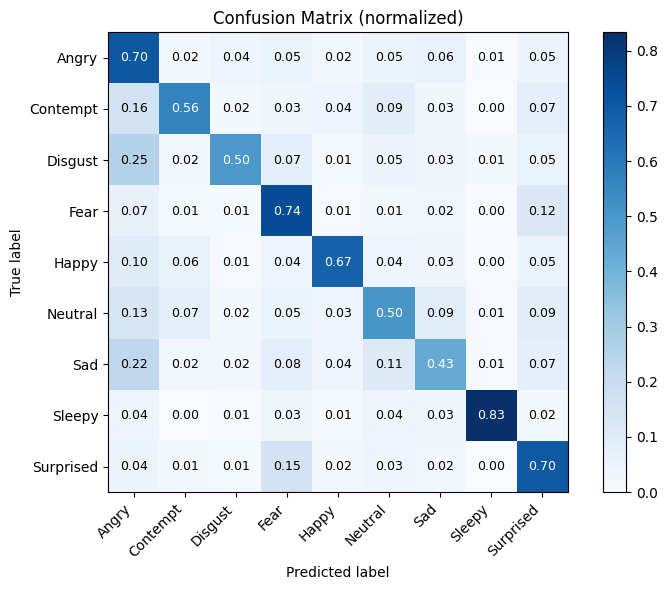

Saved trial to: ..\artifacts\trials\2025-11-18_14-21-43_lr_2p5e-4


{'val_accuracy': 0.6256994009017944,
 'test_accuracy': 0.6141539216041565,
 'test_f1_macro': 0.6043105899327962,
 'epochs_trained': 35}

In [6]:
# Learning Rate Reduction
lr_slow_cfg = json.loads(json.dumps(BASELINE))
lr_slow_cfg["learning_rate"] = 2.5e-4
run_id, metrics = run_experiment(lr_slow_cfg, tag="lr_2p5e-4")
metrics

## Run optimization: Higher Dropout

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 233s 309ms/step - accuracy: 0.1841 - loss: 2.1213 - val_accuracy: 0.1858 - val_loss: 2.2226 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 220s 296ms/step - accuracy: 0.2934 - loss: 1.8140 - val_accuracy: 0.2647 - val_loss: 2.0743 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 216s 290ms/step - accuracy: 0.3666 - loss: 1.6425 - val_accuracy: 0.3455 - val_loss: 1.8826 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 216s 291ms/step - accuracy: 0.4231 - loss: 1.5235 - val_accuracy: 0.4494 - val_loss: 1.5640 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 216s 291ms/step - accuracy: 0.4666 - loss: 1.4282 - val_accuracy: 0.4645 - val_loss: 1.5638 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 216s 290ms/step - accuracy: 0.4961 - loss: 1.3667 - val_accuracy: 0.4316 - val_loss: 1.7254 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 215s 289ms/step - accura

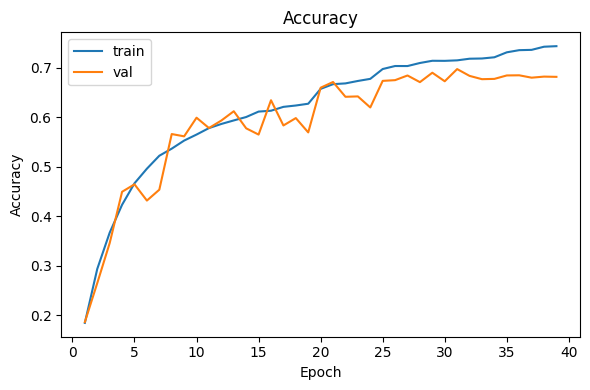

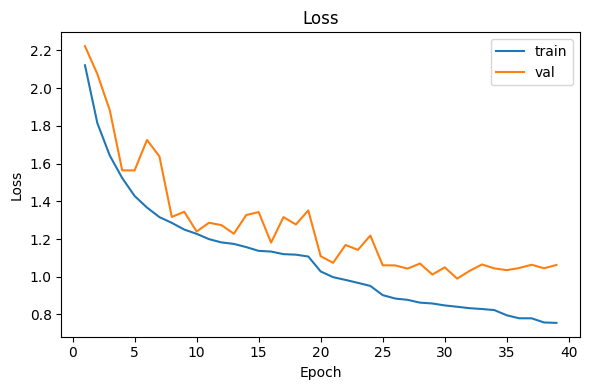


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.62      0.72      0.67      1755
    Contempt       0.45      0.74      0.56       404
     Disgust       0.64      0.57      0.60       675
        Fear       0.64      0.69      0.66       813
       Happy       0.93      0.75      0.83      2188
     Neutral       0.59      0.42      0.49       895
         Sad       0.66      0.67      0.66      1882
      Sleepy       0.87      0.88      0.88       168
   Surprised       0.70      0.75      0.72      1408

    accuracy                           0.69     10188
   macro avg       0.68      0.69      0.68     10188
weighted avg       0.70      0.69      0.69     10188



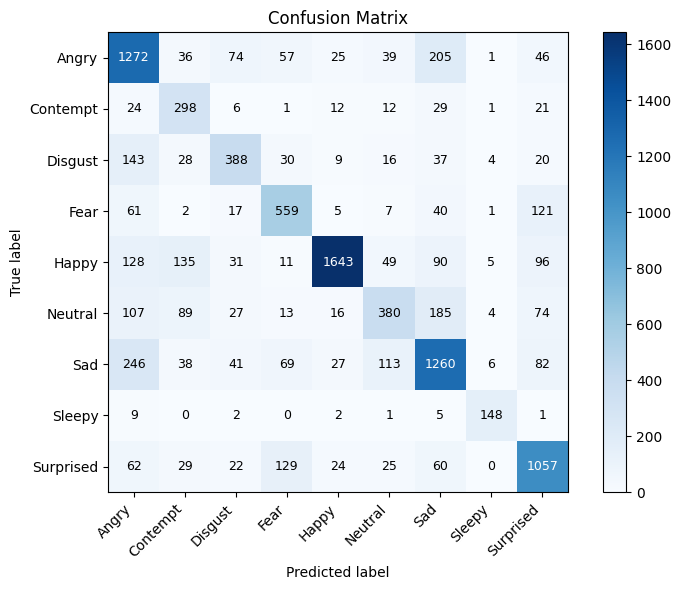

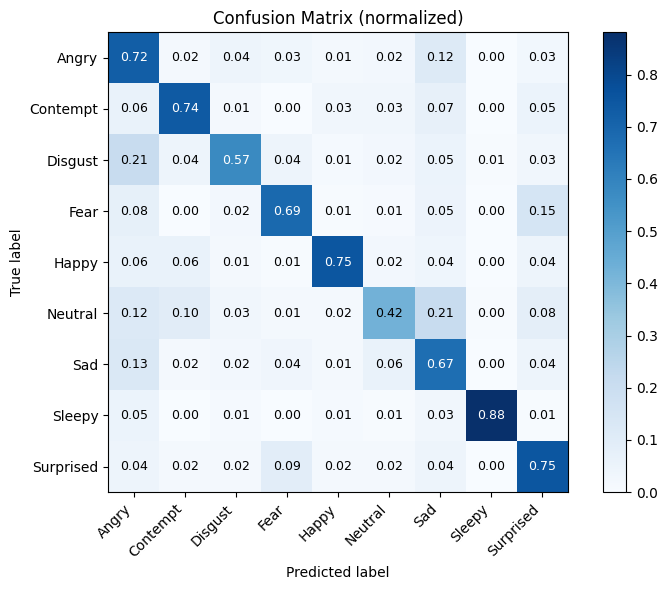

Saved trial to: ..\artifacts\trials\2025-11-19_07-53-03_dropout_0p5


{'val_accuracy': 0.6976538896560669,
 'test_accuracy': 0.6875736117362976,
 'test_f1_macro': 0.6765913876688597,
 'epochs_trained': 39}

In [7]:
# Higher Dropout (stronger regularization)
dropout_high_cfg = json.loads(json.dumps(BASELINE))
dropout_high_cfg["dropout"] = 0.5
run_id, metrics = run_experiment(dropout_high_cfg, tag="dropout_0p5")
metrics

## Run optimization: Lower Dropout

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 223s 297ms/step - accuracy: 0.2019 - loss: 2.0636 - val_accuracy: 0.1386 - val_loss: 2.4245 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 223s 300ms/step - accuracy: 0.3134 - loss: 1.7696 - val_accuracy: 0.1294 - val_loss: 2.6782 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 223s 301ms/step - accuracy: 0.3976 - loss: 1.5876 - val_accuracy: 0.3839 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 223s 301ms/step - accuracy: 0.4476 - loss: 1.4708 - val_accuracy: 0.4176 - val_loss: 1.6915 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 223s 300ms/step - accuracy: 0.4848 - loss: 1.3905 - val_accuracy: 0.4444 - val_loss: 1.6098 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 224s 301ms/step - accuracy: 0.5148 - loss: 1.3298 - val_accuracy: 0.4652 - val_loss: 1.5052 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 224s 302ms/step - accura

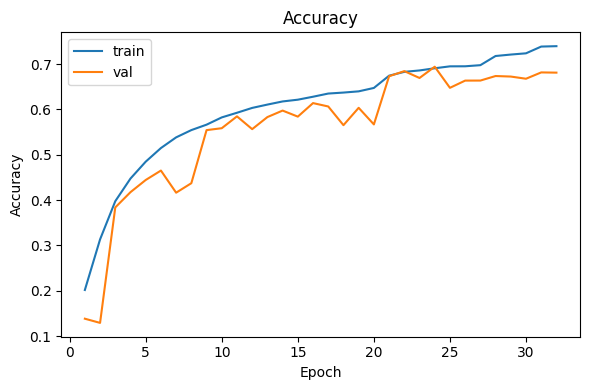

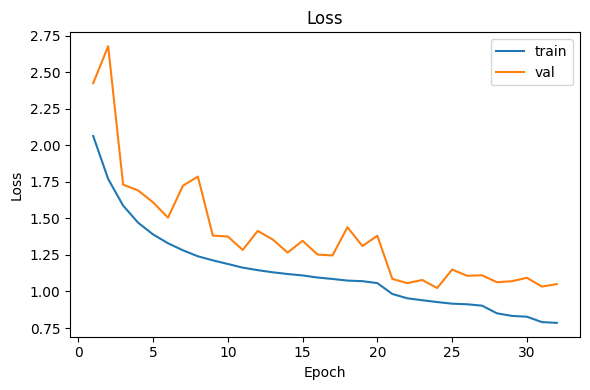


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.65      0.69      0.67      1755
    Contempt       0.52      0.62      0.57       404
     Disgust       0.56      0.64      0.59       675
        Fear       0.65      0.74      0.69       813
       Happy       0.90      0.79      0.84      2188
     Neutral       0.62      0.36      0.45       895
         Sad       0.61      0.73      0.66      1882
      Sleepy       0.64      0.95      0.77       168
   Surprised       0.80      0.67      0.73      1408

    accuracy                           0.69     10188
   macro avg       0.66      0.69      0.66     10188
weighted avg       0.70      0.69      0.69     10188



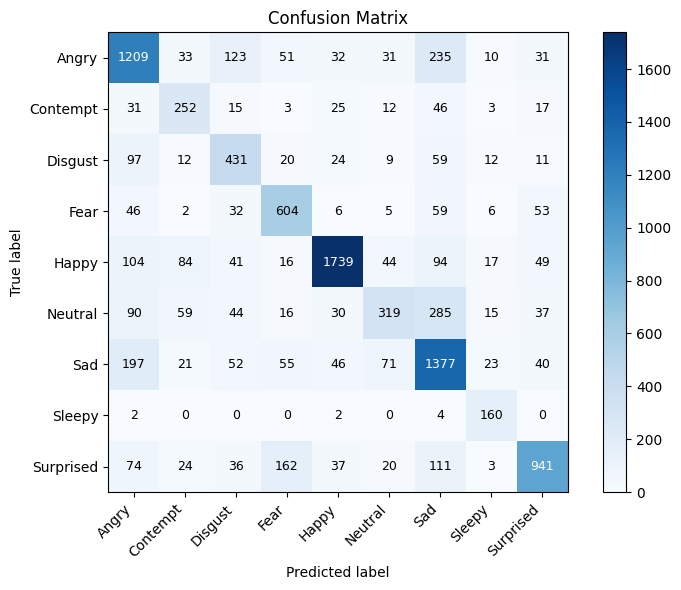

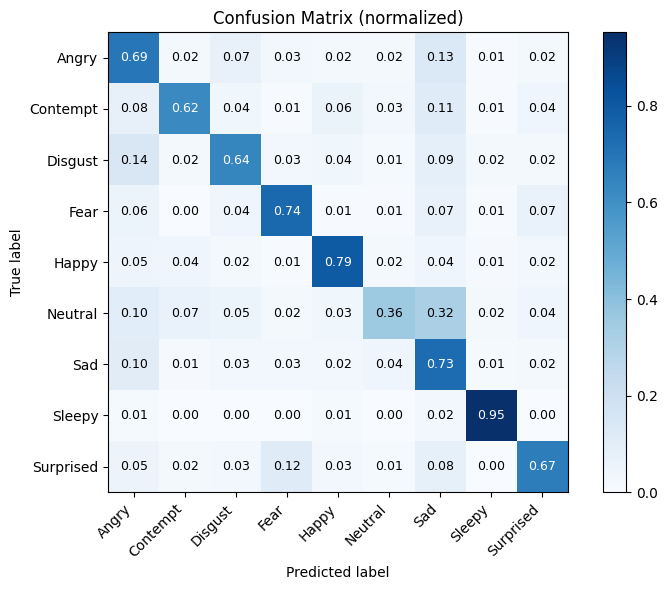

Saved trial to: ..\artifacts\trials\2025-11-19_10-30-34_dropout_0p3


{'val_accuracy': 0.694119930267334,
 'test_accuracy': 0.6902238130569458,
 'test_f1_macro': 0.6644229204822479,
 'epochs_trained': 32}

In [8]:
# Lower Dropout (weaker regularization)
dropout_low_cfg = json.loads(json.dumps(BASELINE))
dropout_low_cfg["dropout"] = 0.3
run_id, metrics = run_experiment(dropout_low_cfg, tag="dropout_0p3")
metrics

## Run optimization: Reduced Filter Depth

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 185s 245ms/step - accuracy: 0.1835 - loss: 2.0902 - val_accuracy: 0.1973 - val_loss: 2.0749 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 182s 245ms/step - accuracy: 0.2838 - loss: 1.8225 - val_accuracy: 0.2173 - val_loss: 2.2921 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 182s 245ms/step - accuracy: 0.3570 - loss: 1.6483 - val_accuracy: 0.3620 - val_loss: 1.9433 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 183s 246ms/step - accuracy: 0.4188 - loss: 1.5242 - val_accuracy: 0.3959 - val_loss: 1.6823 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 182s 245ms/step - accuracy: 0.4562 - loss: 1.4351 - val_accuracy: 0.4055 - val_loss: 1.7581 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 182s 245ms/step - accuracy: 0.4818 - loss: 1.3745 - val_accuracy: 0.4931 - val_loss: 1.4347 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 183s 246ms/step - accura

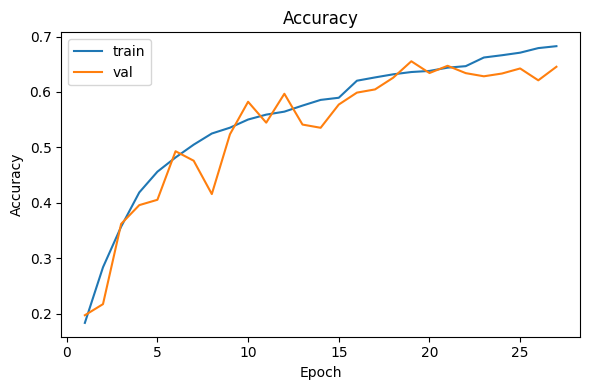

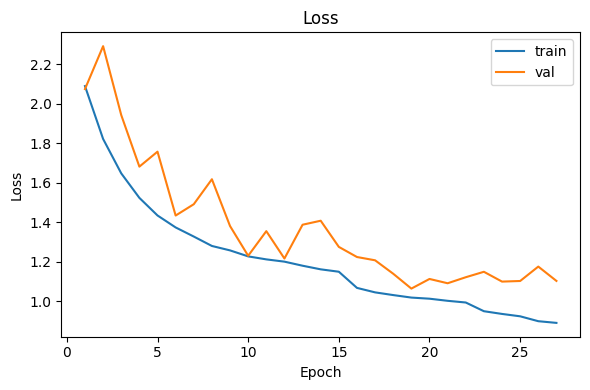


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.59      0.66      0.63      1755
    Contempt       0.43      0.76      0.55       404
     Disgust       0.53      0.58      0.56       675
        Fear       0.48      0.80      0.60       813
       Happy       0.89      0.74      0.81      2188
     Neutral       0.54      0.42      0.48       895
         Sad       0.68      0.52      0.59      1882
      Sleepy       0.73      0.89      0.80       168
   Surprised       0.74      0.65      0.69      1408

    accuracy                           0.64     10188
   macro avg       0.62      0.67      0.63     10188
weighted avg       0.67      0.64      0.65     10188



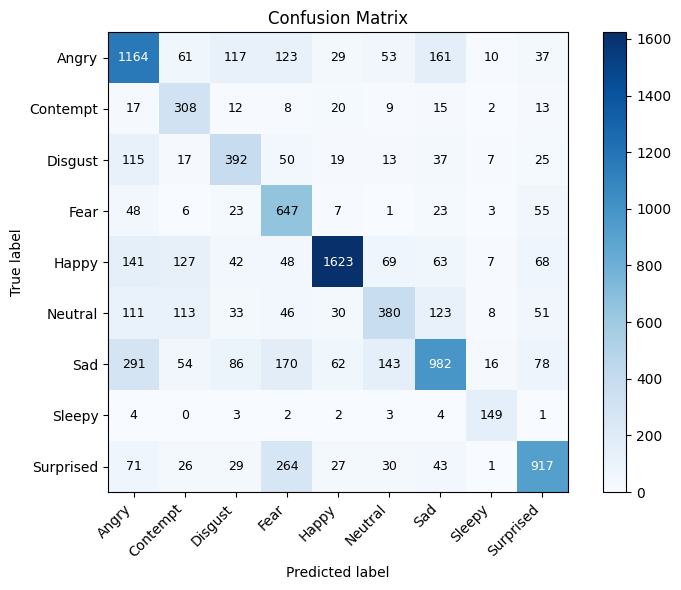

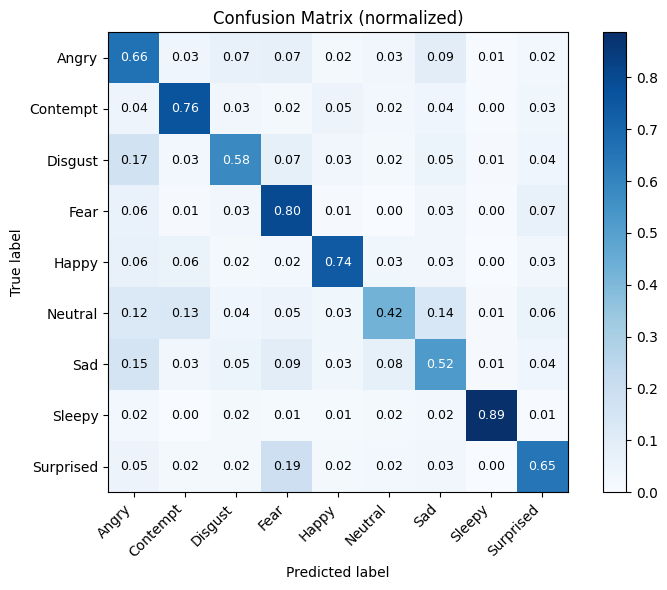

Saved trial to: ..\artifacts\trials\2025-11-19_13-04-26_filters_light


{'val_accuracy': 0.6553450226783752,
 'test_accuracy': 0.6440910696983337,
 'test_f1_macro': 0.6332912764529219,
 'epochs_trained': 27}

In [9]:
# Reduced Filter Depth (lighter model)
filters_light_cfg = json.loads(json.dumps(BASELINE))
filters_light_cfg["filters"] = [32, 64, 96, 128]
run_id, metrics = run_experiment(filters_light_cfg, tag="filters_light")
metrics

## Run optimization: Increased Early Filter Depth

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 263s 351ms/step - accuracy: 0.1894 - loss: 2.1074 - val_accuracy: 0.1958 - val_loss: 2.5759 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 266s 358ms/step - accuracy: 0.2991 - loss: 1.7981 - val_accuracy: 0.3268 - val_loss: 1.8877 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 266s 358ms/step - accuracy: 0.3738 - loss: 1.6243 - val_accuracy: 0.4091 - val_loss: 1.6650 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 267s 359ms/step - accuracy: 0.4335 - loss: 1.5094 - val_accuracy: 0.3943 - val_loss: 1.7881 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 266s 358ms/step - accuracy: 0.4706 - loss: 1.4246 - val_accuracy: 0.3700 - val_loss: 1.8885 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 267s 360ms/step - accuracy: 0.5009 - loss: 1.3600 - val_accuracy: 0.4511 - val_loss: 1.6701 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 267s 359ms/step - accura

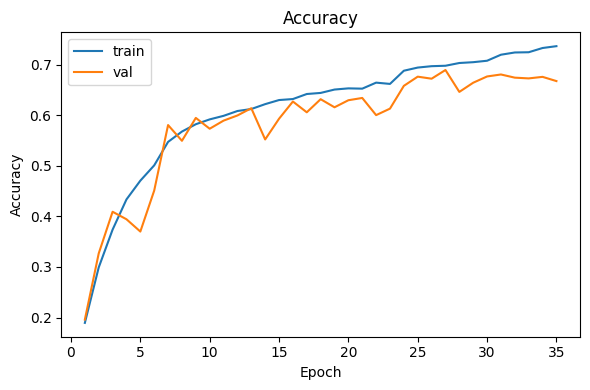

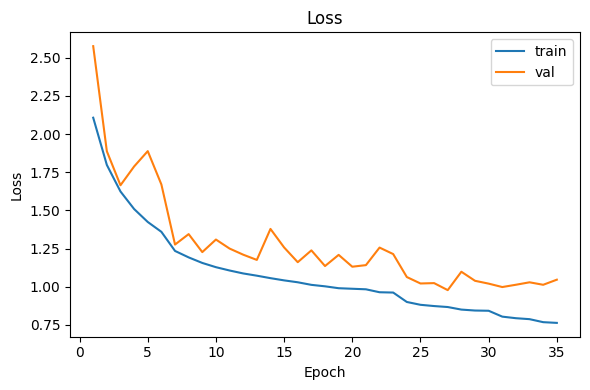


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.69      0.67      0.68      1755
    Contempt       0.45      0.71      0.55       404
     Disgust       0.58      0.65      0.61       675
        Fear       0.64      0.74      0.68       813
       Happy       0.94      0.71      0.81      2188
     Neutral       0.57      0.44      0.50       895
         Sad       0.61      0.70      0.65      1882
      Sleepy       0.82      0.88      0.85       168
   Surprised       0.70      0.73      0.71      1408

    accuracy                           0.68     10188
   macro avg       0.67      0.69      0.67     10188
weighted avg       0.70      0.68      0.68     10188



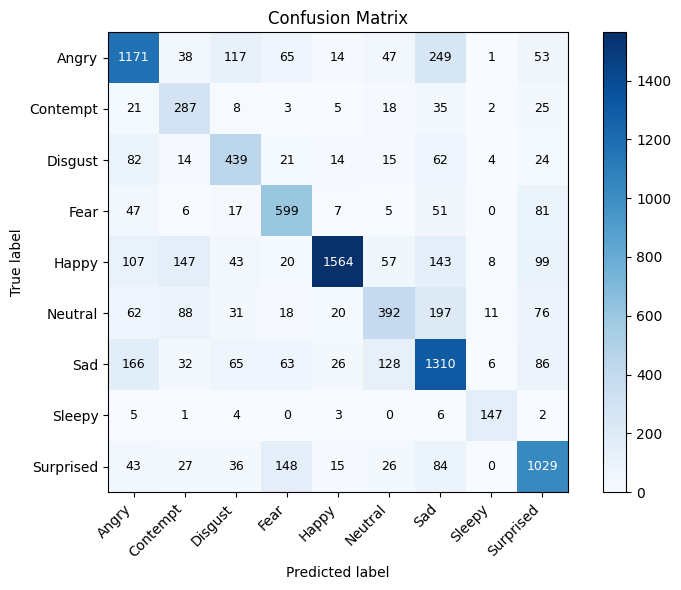

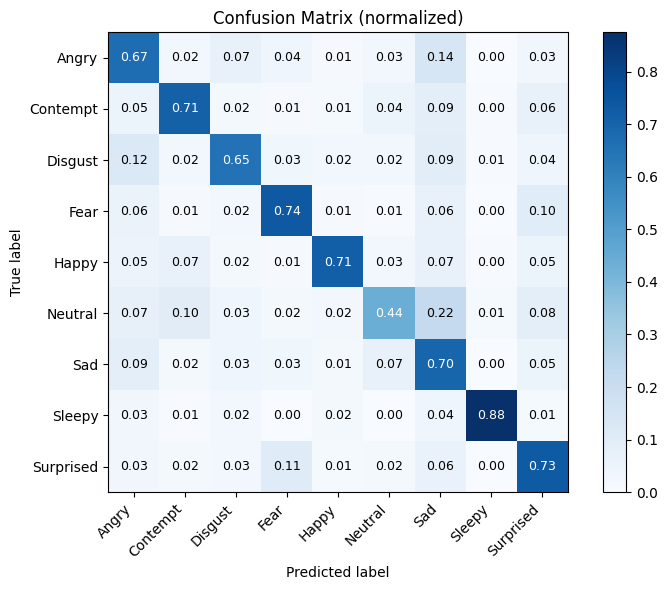

Saved trial to: ..\artifacts\trials\2025-11-19_16-26-26_filters_richfront


{'val_accuracy': 0.6895062327384949,
 'test_accuracy': 0.6809972524642944,
 'test_f1_macro': 0.6714190870159392,
 'epochs_trained': 35}

In [10]:
# Increased Early Filter Depth (richer low-level features)
filters_richfront_cfg = json.loads(json.dumps(BASELINE))
filters_richfront_cfg["filters"] = [48, 64, 128, 256]
run_id, metrics = run_experiment(filters_richfront_cfg, tag="filters_richfront")
metrics

## Run optimization: Smaller Batch Size

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 243s 324ms/step - accuracy: 0.1850 - loss: 2.0852 - val_accuracy: 0.2351 - val_loss: 2.0591 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 230s 310ms/step - accuracy: 0.2971 - loss: 1.7971 - val_accuracy: 0.3028 - val_loss: 1.8830 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 230s 310ms/step - accuracy: 0.3742 - loss: 1.6266 - val_accuracy: 0.4714 - val_loss: 1.5007 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 228s 307ms/step - accuracy: 0.4313 - loss: 1.5106 - val_accuracy: 0.4150 - val_loss: 1.6317 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 227s 305ms/step - accuracy: 0.4750 - loss: 1.4115 - val_accuracy: 0.4350 - val_loss: 1.6556 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 227s 305ms/step - accuracy: 0.5053 - loss: 1.3437 - val_accuracy: 0.4262 - val_loss: 1.6451 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 227s 305ms/step - accura

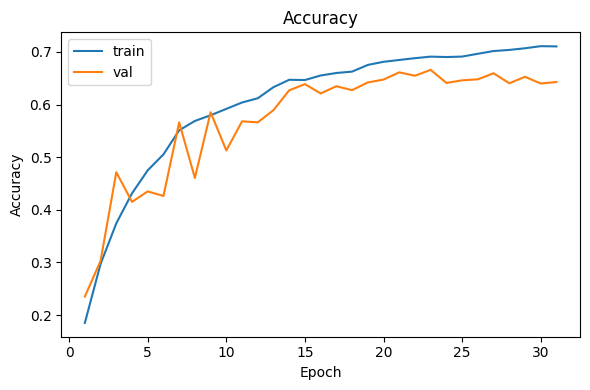

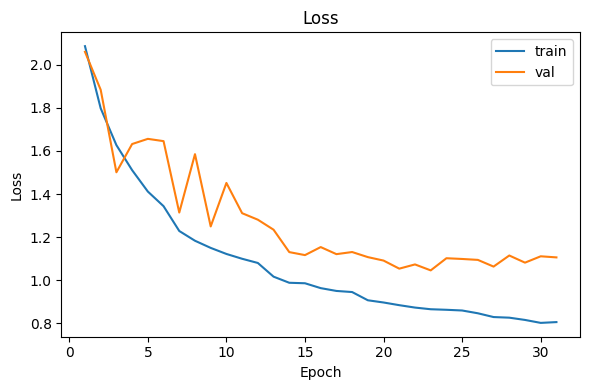


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.60      0.69      0.64      1755
    Contempt       0.40      0.75      0.52       404
     Disgust       0.53      0.58      0.56       675
        Fear       0.63      0.70      0.66       813
       Happy       0.91      0.69      0.78      2188
     Neutral       0.51      0.53      0.52       895
         Sad       0.68      0.58      0.62      1882
      Sleepy       0.87      0.85      0.86       168
   Surprised       0.72      0.71      0.71      1408

    accuracy                           0.66     10188
   macro avg       0.65      0.68      0.65     10188
weighted avg       0.68      0.66      0.66     10188



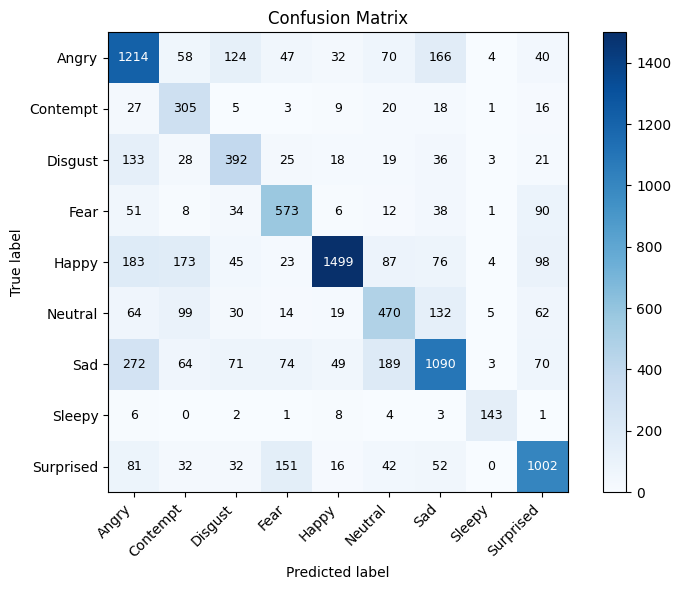

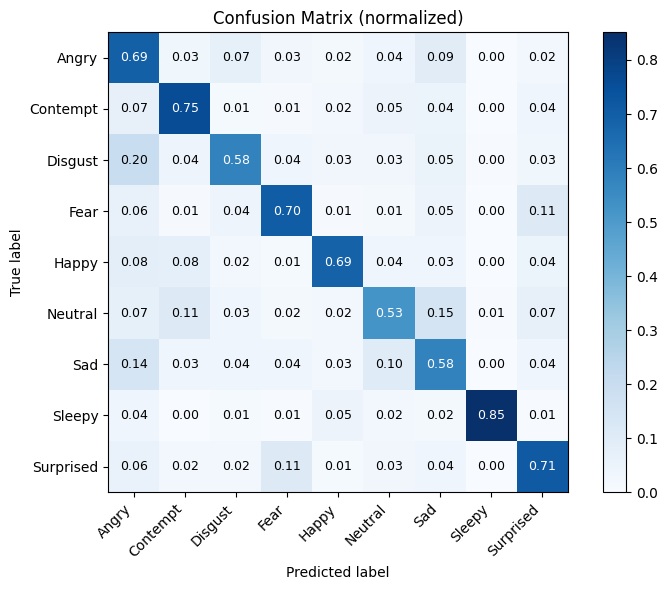

Saved trial to: ..\artifacts\trials\2025-11-19_20-27-17_batch32


{'val_accuracy': 0.6659467816352844,
 'test_accuracy': 0.6564585566520691,
 'test_f1_macro': 0.6535609482304484,
 'epochs_trained': 31}

In [11]:
# Smaller Batch Size (adds gradient noise regularization)
batch32_cfg = json.loads(json.dumps(BASELINE))
batch32_cfg["batch_size"] = 32
run_id, metrics = run_experiment(batch32_cfg, tag="batch32")
metrics

## Run optimization: Larger Batch Size with Adjusted LR

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 236s 314ms/step - accuracy: 0.2045 - loss: 2.0589 - val_accuracy: 0.1430 - val_loss: 2.2974 - learning_rate: 5.0000e-04
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 228s 307ms/step - accuracy: 0.3055 - loss: 1.7820 - val_accuracy: 0.2538 - val_loss: 2.0219 - learning_rate: 5.0000e-04
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 227s 306ms/step - accuracy: 0.3702 - loss: 1.6195 - val_accuracy: 0.2656 - val_loss: 2.0034 - learning_rate: 5.0000e-04
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 225s 303ms/step - accuracy: 0.4251 - loss: 1.5088 - val_accuracy: 0.4336 - val_loss: 1.6205 - learning_rate: 5.0000e-04
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 225s 303ms/step - accuracy: 0.4614 - loss: 1.4259 - val_accuracy: 0.4906 - val_loss: 1.4600 - learning_rate: 5.0000e-04
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 226s 304ms/step - accuracy: 0.4876 - loss: 1.3589 - val_accuracy: 0.4601 - val_loss: 1.5288 - learning_rate: 5.0000e-04
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 

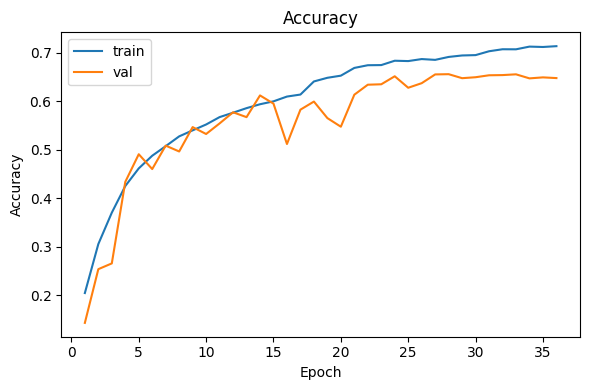

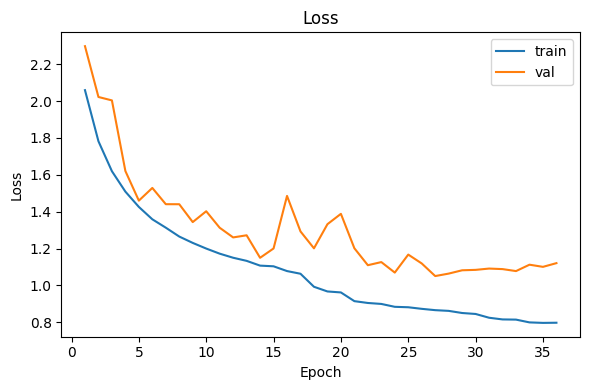


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.65      0.60      0.62      1755
    Contempt       0.38      0.70      0.50       404
     Disgust       0.63      0.49      0.55       675
        Fear       0.55      0.76      0.64       813
       Happy       0.90      0.70      0.78      2188
     Neutral       0.52      0.40      0.46       895
         Sad       0.59      0.65      0.62      1882
      Sleepy       0.77      0.88      0.82       168
   Surprised       0.67      0.72      0.69      1408

    accuracy                           0.64     10188
   macro avg       0.63      0.66      0.63     10188
weighted avg       0.66      0.64      0.65     10188



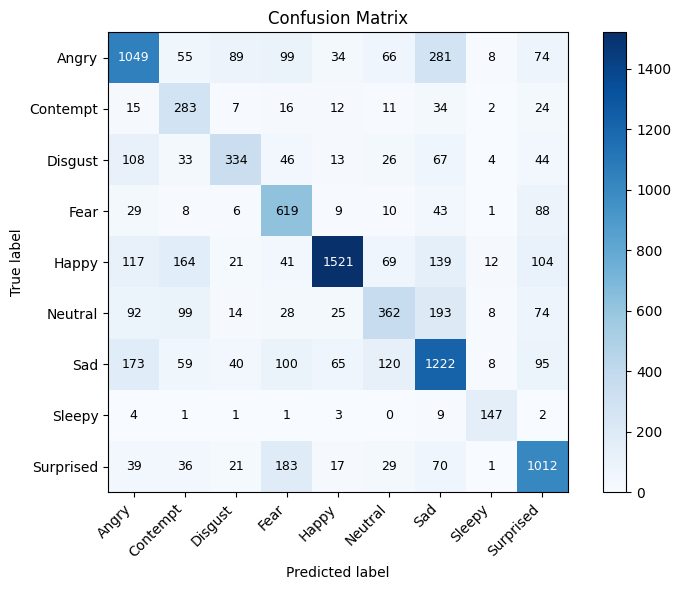

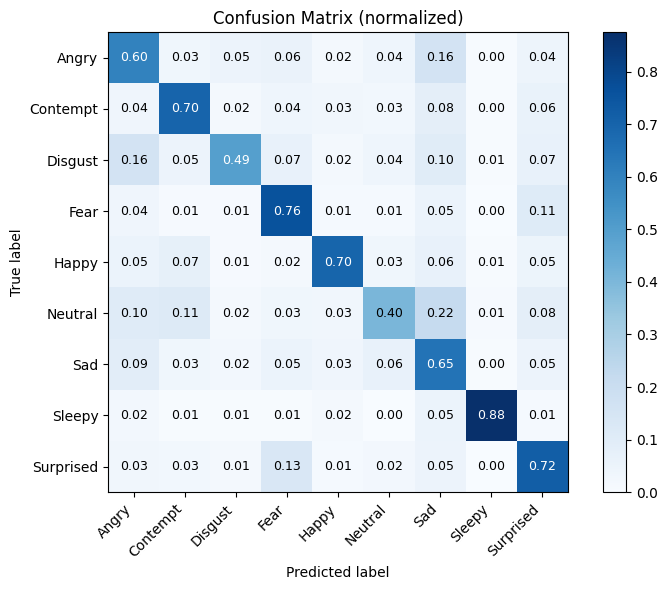

Saved trial to: ..\artifacts\trials\2025-11-20_05-03-44_batch128_lr5e-4


{'val_accuracy': 0.6556395292282104,
 'test_accuracy': 0.6428150534629822,
 'test_f1_macro': 0.6305605632059208,
 'epochs_trained': 36}

In [12]:

# Larger Batch with Adjusted LR (stability focus)
batch128_cfg = json.loads(json.dumps(BASELINE))
batch128_cfg["batch_size"] = 128
batch128_cfg["learning_rate"] = 5e-4
run_id, metrics = run_experiment(batch128_cfg, tag="batch128_lr5e-4")
metrics

## Run optimization: Stronger L2 Regularization

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 226s 302ms/step - accuracy: 0.2025 - loss: 2.2122 - val_accuracy: 0.1735 - val_loss: 2.3504 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 225s 303ms/step - accuracy: 0.3096 - loss: 1.8561 - val_accuracy: 0.1745 - val_loss: 2.4156 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 225s 303ms/step - accuracy: 0.3780 - loss: 1.7013 - val_accuracy: 0.2745 - val_loss: 2.2005 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 225s 303ms/step - accuracy: 0.4306 - loss: 1.5942 - val_accuracy: 0.3731 - val_loss: 1.8302 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 226s 304ms/step - accuracy: 0.4674 - loss: 1.5256 - val_accuracy: 0.4510 - val_loss: 1.6595 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 227s 305ms/step - accuracy: 0.4905 - loss: 1.4749 - val_accuracy: 0.4989 - val_loss: 1.5704 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 226s 304ms/step - accura

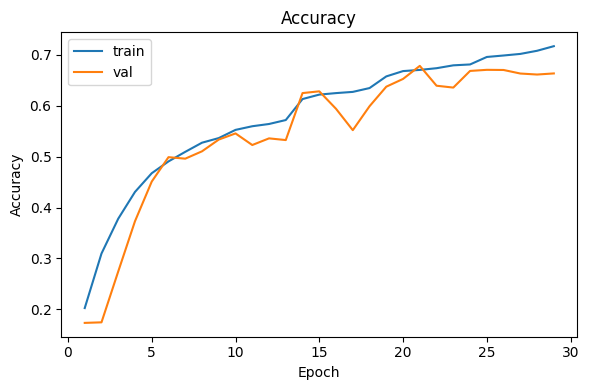

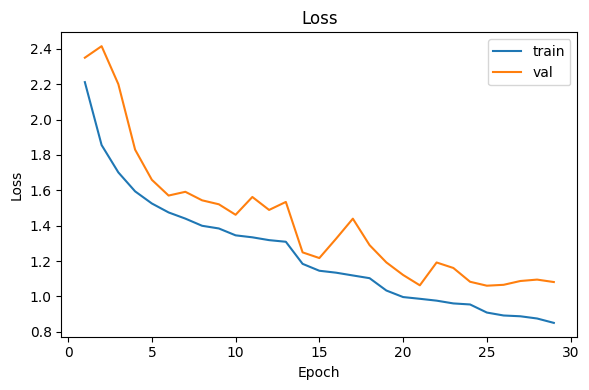


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.63      0.67      0.65      1755
    Contempt       0.39      0.77      0.52       404
     Disgust       0.49      0.65      0.56       675
        Fear       0.64      0.67      0.65       813
       Happy       0.88      0.77      0.82      2188
     Neutral       0.58      0.38      0.46       895
         Sad       0.67      0.59      0.63      1882
      Sleepy       0.69      0.89      0.77       168
   Surprised       0.71      0.72      0.71      1408

    accuracy                           0.66     10188
   macro avg       0.63      0.68      0.64     10188
weighted avg       0.68      0.66      0.67     10188



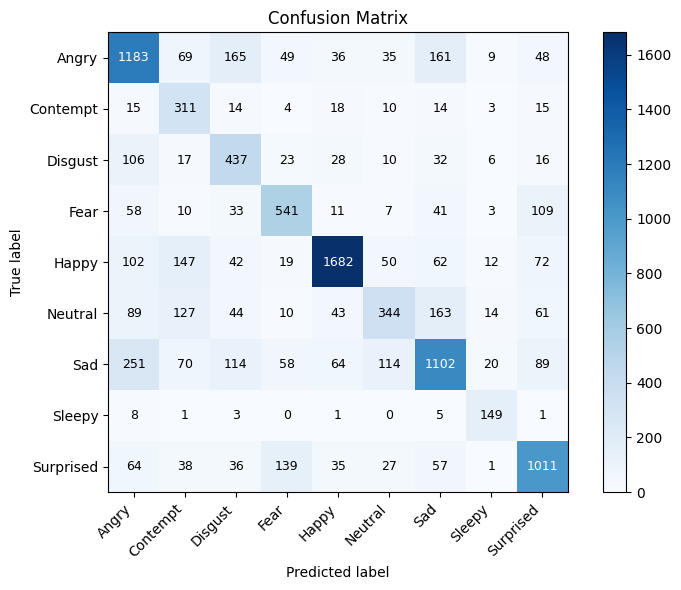

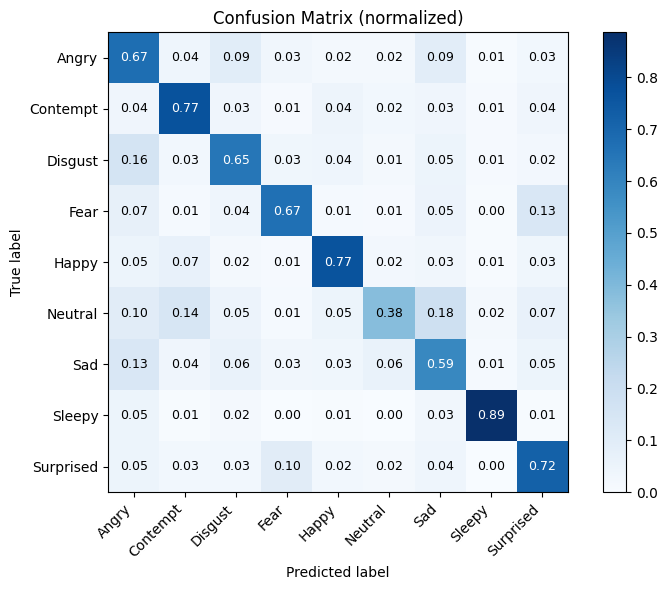

Saved trial to: ..\artifacts\trials\2025-11-20_12-21-38_l2_5e-4


{'val_accuracy': 0.6781191825866699,
 'test_accuracy': 0.6635257005691528,
 'test_f1_macro': 0.6422616228618101,
 'epochs_trained': 29}

In [13]:
# Stronger L2 Regularization (weight decay)
l2_stronger_cfg = json.loads(json.dumps(BASELINE))
l2_stronger_cfg["l2"] = 5e-4
run_id, metrics = run_experiment(l2_stronger_cfg, tag="l2_5e-4")
metrics

## Run optimization: Enhanced Data Augmentation

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 237s 316ms/step - accuracy: 0.1729 - loss: 2.1468 - val_accuracy: 0.1575 - val_loss: 2.2967 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 238s 320ms/step - accuracy: 0.2451 - loss: 1.9373 - val_accuracy: 0.1977 - val_loss: 2.2721 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 236s 317ms/step - accuracy: 0.3100 - loss: 1.7747 - val_accuracy: 0.2578 - val_loss: 2.2012 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 233s 314ms/step - accuracy: 0.3527 - loss: 1.6758 - val_accuracy: 0.2445 - val_loss: 2.1322 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 233s 313ms/step - accuracy: 0.4002 - loss: 1.5894 - val_accuracy: 0.2996 - val_loss: 1.9563 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 233s 314ms/step - accuracy: 0.4362 - loss: 1.5230 - val_accuracy: 0.4040 - val_loss: 1.7511 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 233s 314ms/step - accura

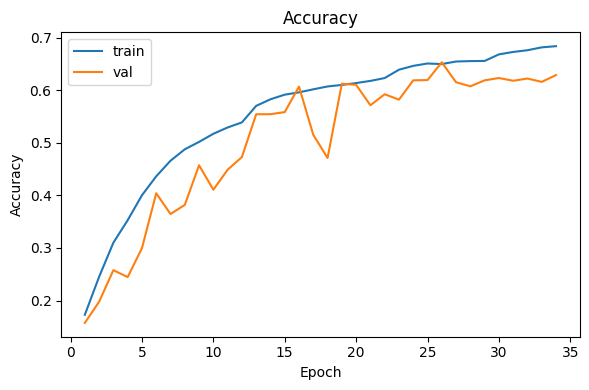

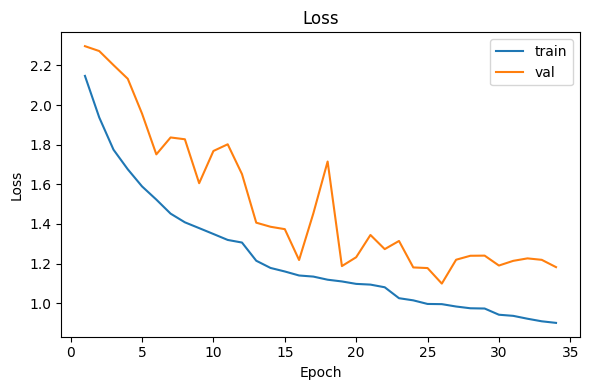


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.58      0.65      0.61      1755
    Contempt       0.34      0.72      0.46       404
     Disgust       0.55      0.53      0.54       675
        Fear       0.59      0.66      0.62       813
       Happy       0.88      0.73      0.80      2188
     Neutral       0.58      0.39      0.46       895
         Sad       0.63      0.56      0.60      1882
      Sleepy       0.71      0.92      0.80       168
   Surprised       0.67      0.72      0.70      1408

    accuracy                           0.64     10188
   macro avg       0.61      0.65      0.62     10188
weighted avg       0.66      0.64      0.64     10188



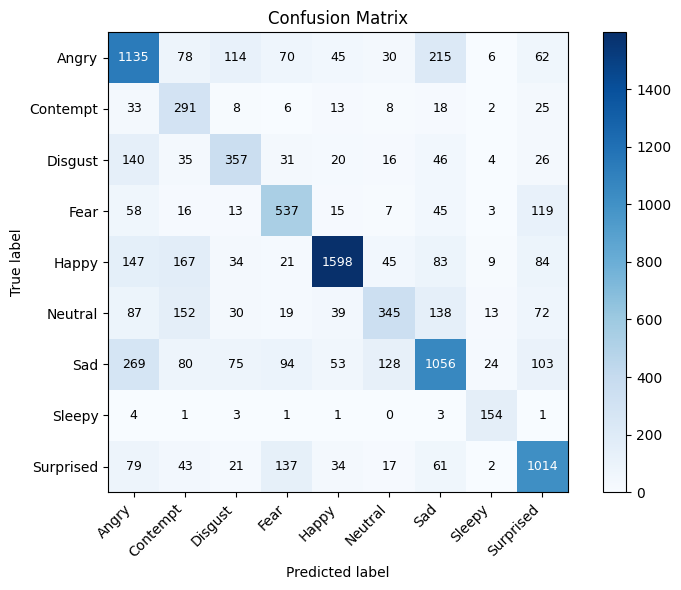

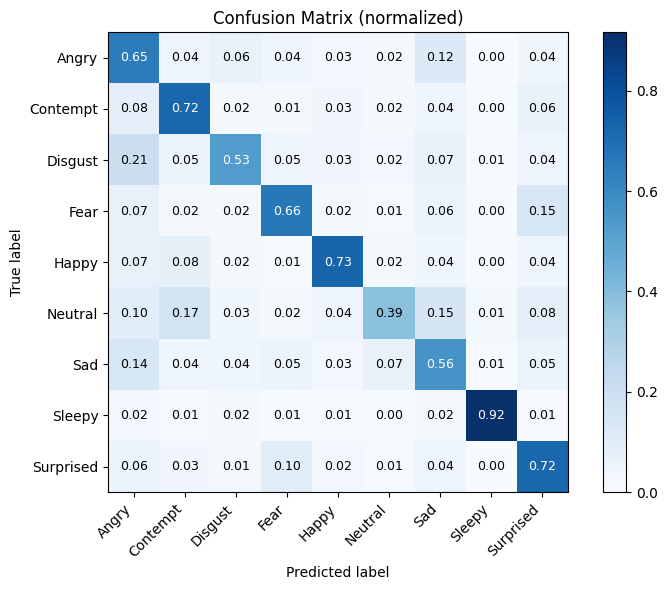

Saved trial to: ..\artifacts\trials\2025-11-20_17-52-52_aug_stronger


{'val_accuracy': 0.6529890894889832,
 'test_accuracy': 0.6367294788360596,
 'test_f1_macro': 0.6201868350076964,
 'epochs_trained': 34}

In [14]:
# Enhanced Data Augmentation (data-driven regularization)
aug_stronger_cfg = json.loads(json.dumps(BASELINE))
aug_stronger_cfg["augment"]["rotation"] = 0.15   # baseline was 0.08
aug_stronger_cfg["augment"]["zoom"] = 0.20       # baseline was 0.10
run_id, metrics = run_experiment(aug_stronger_cfg, tag="aug_stronger")
metrics

## Run optimization: Lower Dropout with Stronger L2 Regularization

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 241s 322ms/step - accuracy: 0.2135 - loss: 2.1666 - val_accuracy: 0.2573 - val_loss: 2.1269 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 244s 329ms/step - accuracy: 0.3232 - loss: 1.8110 - val_accuracy: 0.3424 - val_loss: 1.8537 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 245s 329ms/step - accuracy: 0.3953 - loss: 1.6665 - val_accuracy: 0.3541 - val_loss: 1.9505 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 244s 329ms/step - accuracy: 0.4404 - loss: 1.5784 - val_accuracy: 0.3483 - val_loss: 1.9557 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 245s 329ms/step - accuracy: 0.4767 - loss: 1.4993 - val_accuracy: 0.4455 - val_loss: 1.7628 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 244s 329ms/step - accuracy: 0.5007 - loss: 1.4456 - val_accuracy: 0.3961 - val_loss: 1.9593 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 246s 331ms/step - accura

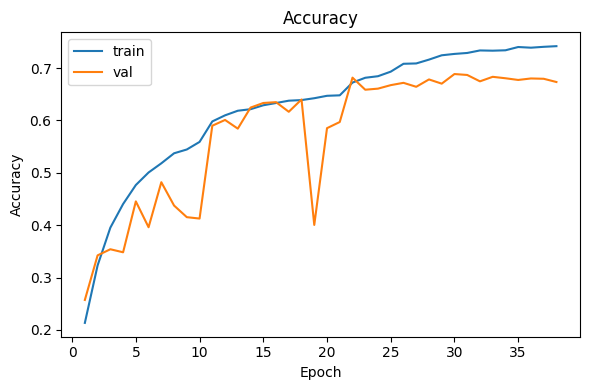

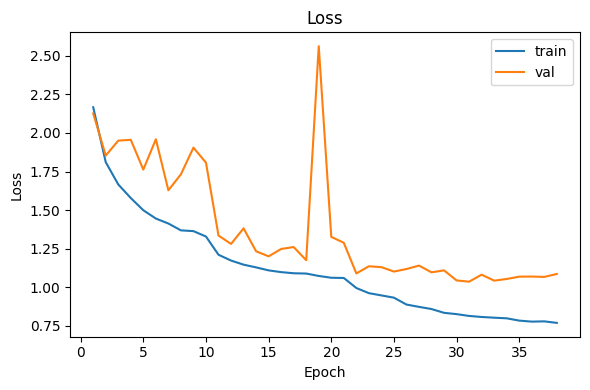


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.65      0.66      0.66      1755
    Contempt       0.43      0.70      0.53       404
     Disgust       0.54      0.66      0.59       675
        Fear       0.67      0.73      0.70       813
       Happy       0.93      0.72      0.81      2188
     Neutral       0.60      0.44      0.51       895
         Sad       0.68      0.62      0.65      1882
      Sleepy       0.81      0.87      0.84       168
   Surprised       0.62      0.78      0.69      1408

    accuracy                           0.67     10188
   macro avg       0.66      0.69      0.66     10188
weighted avg       0.69      0.67      0.68     10188



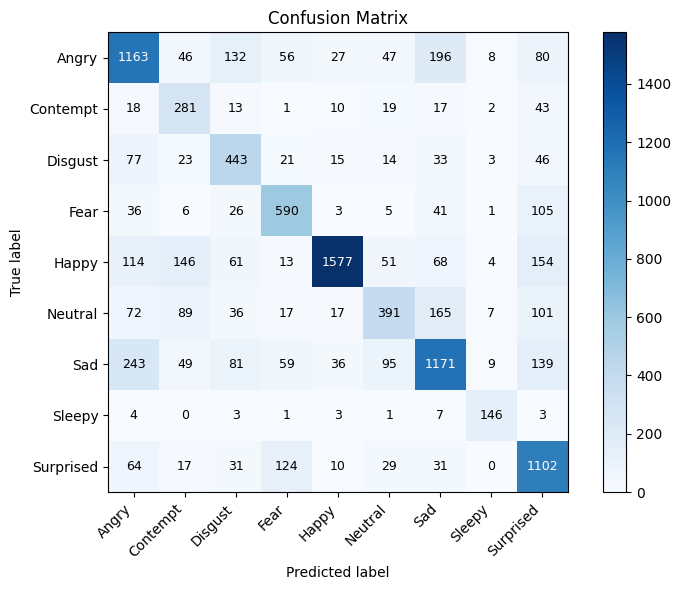

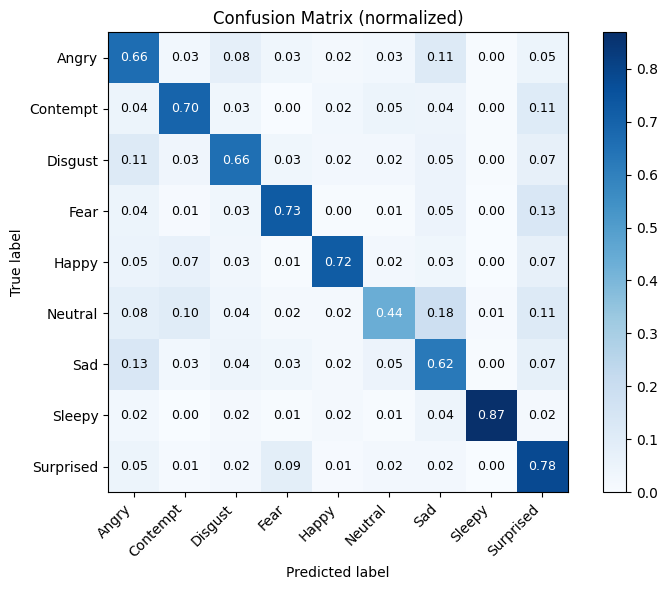

Saved trial to: ..\artifacts\trials\2025-11-21_05-19-46_dropout_0p3_l2_5e-4


{'val_accuracy': 0.688622772693634,
 'test_accuracy': 0.6737338304519653,
 'test_f1_macro': 0.663302425194798,
 'epochs_trained': 38}

In [15]:
# Lower Dropout with Stronger L2 Regularization
dropout03_l2_cfg = json.loads(json.dumps(BASELINE))
dropout03_l2_cfg["dropout"] = 0.3
dropout03_l2_cfg["l2"] = 5e-4
run_id, metrics = run_experiment(dropout03_l2_cfg, tag="dropout_0p3_l2_5e-4")
metrics

## Run optimization: Higher Dropout with Stronger L2 Regularization

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 243s 324ms/step - accuracy: 0.1828 - loss: 2.2641 - val_accuracy: 0.1346 - val_loss: 2.4487 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 245s 330ms/step - accuracy: 0.2794 - loss: 1.9101 - val_accuracy: 0.2179 - val_loss: 2.4713 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 247s 332ms/step - accuracy: 0.3479 - loss: 1.7455 - val_accuracy: 0.2087 - val_loss: 2.3190 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 246s 331ms/step - accuracy: 0.4114 - loss: 1.6366 - val_accuracy: 0.3680 - val_loss: 1.9562 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 246s 331ms/step - accuracy: 0.4522 - loss: 1.5582 - val_accuracy: 0.3061 - val_loss: 2.2196 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 246s 331ms/step - accuracy: 0.4823 - loss: 1.4960 - val_accuracy: 0.2572 - val_loss: 2.6006 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 247s 332ms/step - accura

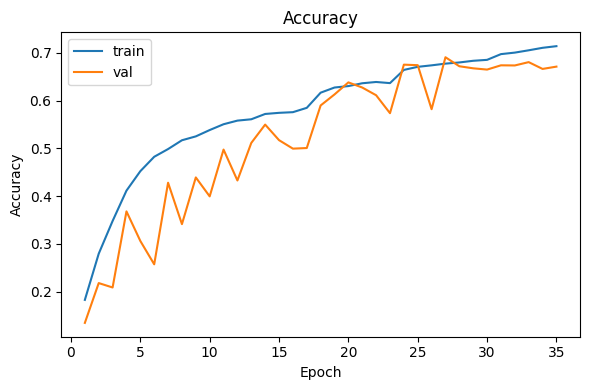

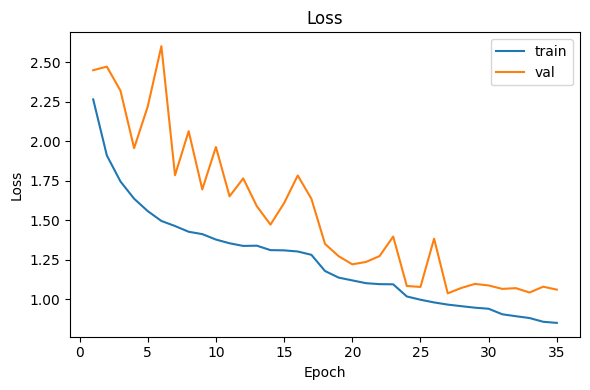


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.68      0.67      0.68      1755
    Contempt       0.37      0.78      0.50       404
     Disgust       0.64      0.54      0.58       675
        Fear       0.61      0.73      0.66       813
       Happy       0.91      0.77      0.83      2188
     Neutral       0.51      0.54      0.53       895
         Sad       0.71      0.61      0.66      1882
      Sleepy       0.54      0.95      0.69       168
   Surprised       0.74      0.72      0.73      1408

    accuracy                           0.68     10188
   macro avg       0.63      0.70      0.65     10188
weighted avg       0.71      0.68      0.69     10188



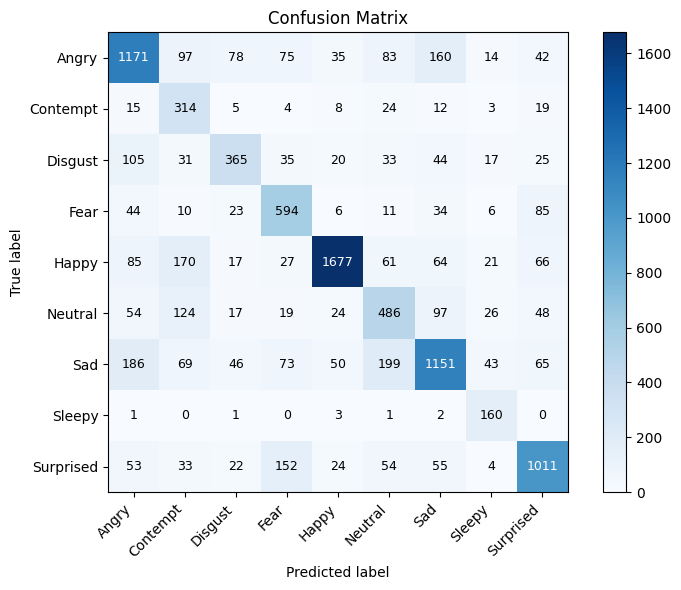

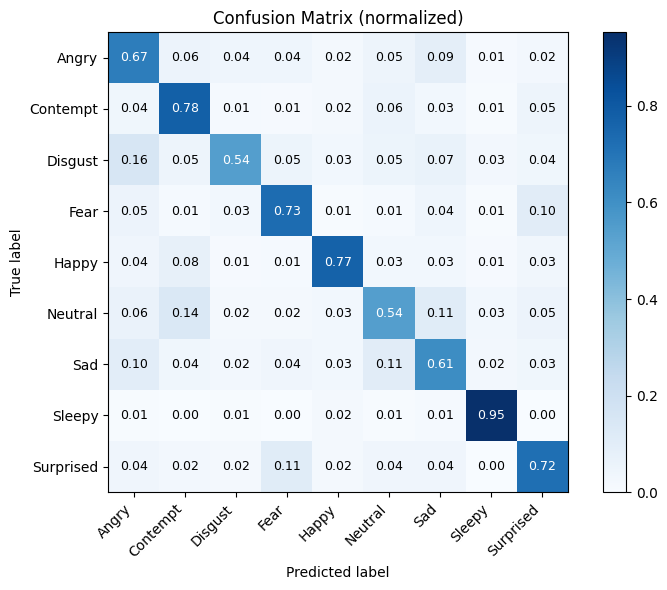

Saved trial to: ..\artifacts\trials\2025-11-21_08-07-18_dropout_0p5_l2_5e-4


{'val_accuracy': 0.6906841993331909,
 'test_accuracy': 0.6801138520240784,
 'test_f1_macro': 0.6513349063206845,
 'epochs_trained': 35}

In [16]:
# Higher Dropout with Stronger L2 Regularization
dropout05_l2_cfg = json.loads(json.dumps(BASELINE))
dropout05_l2_cfg["dropout"] = 0.5
dropout05_l2_cfg["l2"] = 5e-4
run_id, metrics = run_experiment(dropout05_l2_cfg, tag="dropout_0p5_l2_5e-4")
metrics


## Run optimization: Lower Dropout with Smaller Batch Size

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 249s 333ms/step - accuracy: 0.1995 - loss: 2.0655 - val_accuracy: 0.2279 - val_loss: 2.1732 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 253s 340ms/step - accuracy: 0.3232 - loss: 1.7501 - val_accuracy: 0.2609 - val_loss: 2.0794 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 250s 337ms/step - accuracy: 0.3944 - loss: 1.5891 - val_accuracy: 0.3100 - val_loss: 2.0540 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 253s 340ms/step - accuracy: 0.4515 - loss: 1.4765 - val_accuracy: 0.2975 - val_loss: 2.5242 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 260s 349ms/step - accuracy: 0.4897 - loss: 1.3798 - val_accuracy: 0.3986 - val_loss: 1.8118 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 250s 336ms/step - accuracy: 0.5152 - loss: 1.3256 - val_accuracy: 0.4641 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 250s 337ms/step - accura

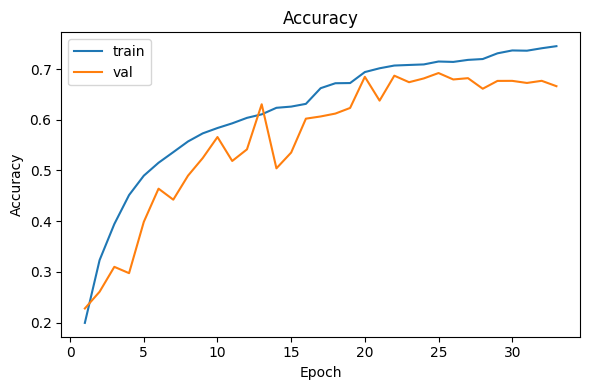

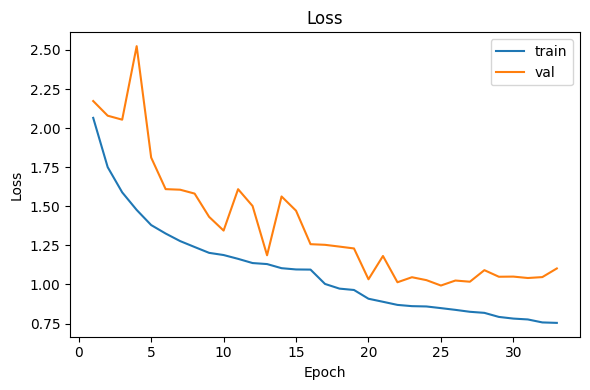


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.65      0.64      0.65      1755
    Contempt       0.47      0.71      0.57       404
     Disgust       0.56      0.63      0.59       675
        Fear       0.62      0.73      0.67       813
       Happy       0.92      0.77      0.84      2188
     Neutral       0.56      0.48      0.51       895
         Sad       0.65      0.66      0.66      1882
      Sleepy       0.79      0.92      0.85       168
   Surprised       0.72      0.73      0.73      1408

    accuracy                           0.68     10188
   macro avg       0.66      0.70      0.67     10188
weighted avg       0.70      0.68      0.69     10188



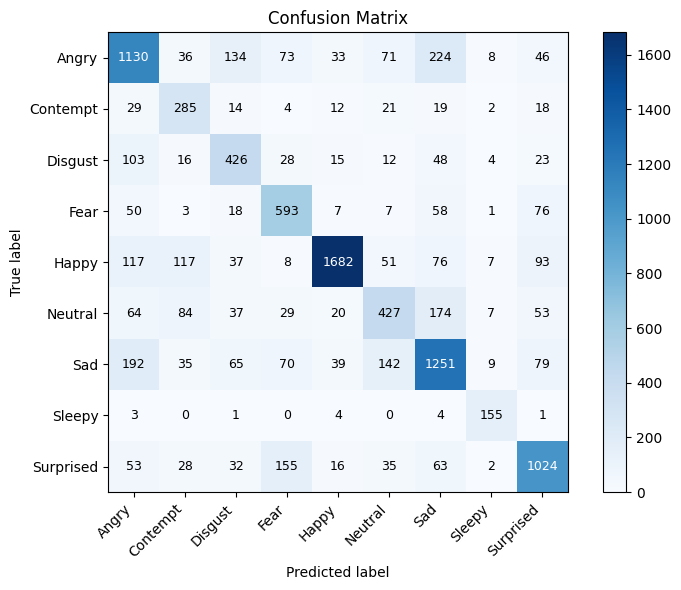

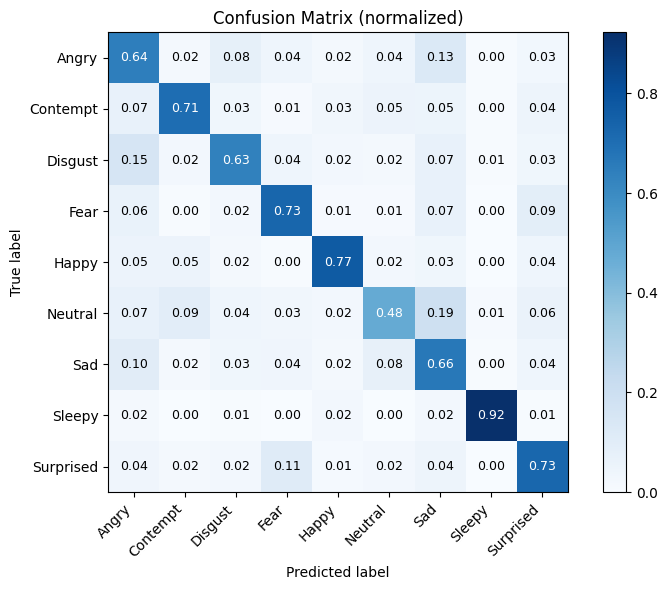

Saved trial to: ..\artifacts\trials\2025-11-21_17-39-50_dropout_0p3_batch32


{'val_accuracy': 0.6920585036277771,
 'test_accuracy': 0.6844326853752136,
 'test_f1_macro': 0.6736999887055639,
 'epochs_trained': 33}

In [17]:
# Lower Dropout with Smaller Batch Size
dropout03_b32_cfg = json.loads(json.dumps(BASELINE))
dropout03_b32_cfg["dropout"] = 0.3
dropout03_b32_cfg["batch_size"] = 32
run_id, metrics = run_experiment(dropout03_b32_cfg, tag="dropout_0p3_batch32")
metrics


## Run optimization: Increased Early Filter Depth with Higher Dropout

Epoch 1/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 296s 395ms/step - accuracy: 0.1735 - loss: 2.1496 - val_accuracy: 0.1879 - val_loss: 2.3366 - learning_rate: 0.0010
Epoch 2/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 296s 398ms/step - accuracy: 0.2647 - loss: 1.8819 - val_accuracy: 0.1562 - val_loss: 2.8075 - learning_rate: 0.0010
Epoch 3/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 291s 392ms/step - accuracy: 0.3436 - loss: 1.6862 - val_accuracy: 0.2710 - val_loss: 2.0737 - learning_rate: 0.0010
Epoch 4/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 293s 395ms/step - accuracy: 0.4054 - loss: 1.5590 - val_accuracy: 0.3856 - val_loss: 1.7410 - learning_rate: 0.0010
Epoch 5/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 291s 391ms/step - accuracy: 0.4494 - loss: 1.4718 - val_accuracy: 0.3409 - val_loss: 2.1143 - learning_rate: 0.0010
Epoch 6/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 293s 394ms/step - accuracy: 0.4845 - loss: 1.3883 - val_accuracy: 0.4613 - val_loss: 1.5875 - learning_rate: 0.0010
Epoch 7/60
743/743 ━━━━━━━━━━━━━━━━━━━━ 294s 395ms/step - accura

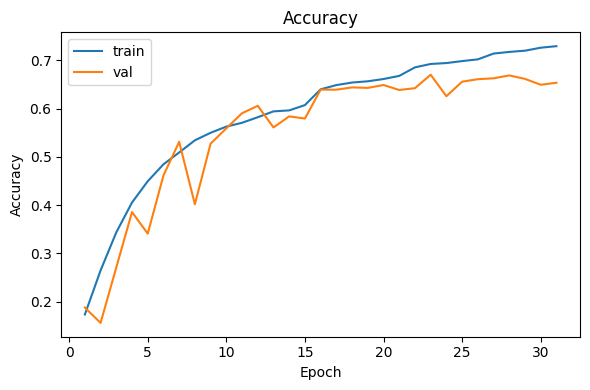

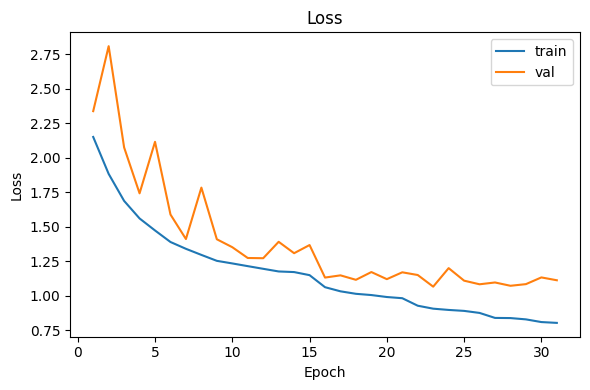


Classification report (test):
               precision    recall  f1-score   support

       Angry       0.62      0.62      0.62      1755
    Contempt       0.39      0.71      0.51       404
     Disgust       0.58      0.57      0.58       675
        Fear       0.56      0.75      0.64       813
       Happy       0.91      0.72      0.80      2188
     Neutral       0.57      0.39      0.46       895
         Sad       0.61      0.68      0.64      1882
      Sleepy       0.76      0.89      0.82       168
   Surprised       0.73      0.69      0.71      1408

    accuracy                           0.66     10188
   macro avg       0.64      0.67      0.64     10188
weighted avg       0.68      0.66      0.66     10188



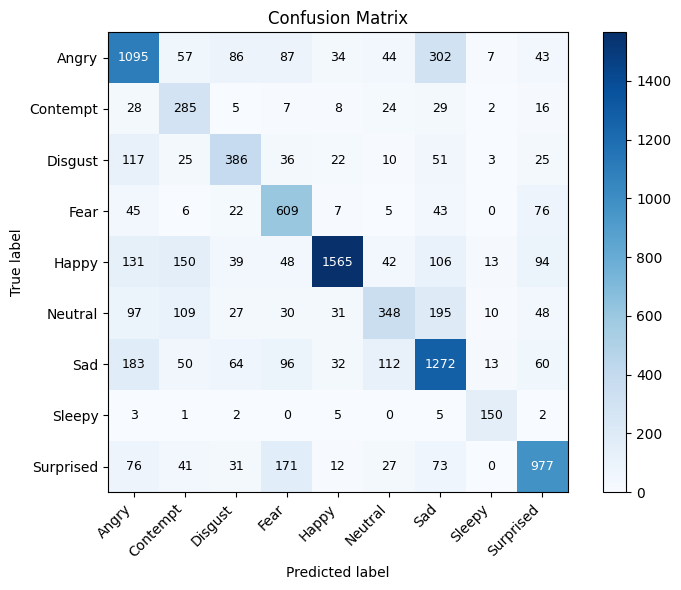

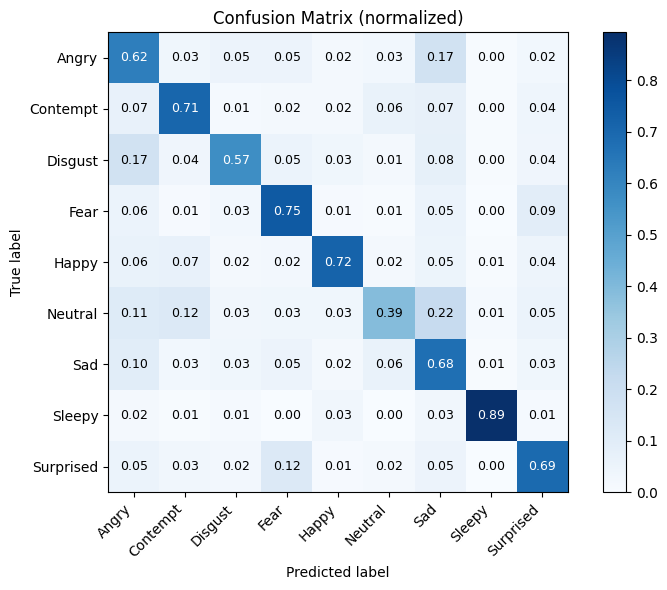

Saved trial to: ..\artifacts\trials\2025-11-22_05-21-29_filters_richfront_dropout_0p5


{'val_accuracy': 0.6699715256690979,
 'test_accuracy': 0.6563604474067688,
 'test_f1_macro': 0.642445081961584,
 'epochs_trained': 31}

In [18]:
# Increased Early Filter Depth with Higher Dropout
richfront_dropout05_cfg = json.loads(json.dumps(BASELINE))
richfront_dropout05_cfg["filters"] = [48, 64, 128, 256]
richfront_dropout05_cfg["dropout"] = 0.5
run_id, metrics = run_experiment(richfront_dropout05_cfg, tag="filters_richfront_dropout_0p5")
metrics


## Promote best-performing model to /artifacts/models directory

In [19]:
# Promote best-performing model

lb_path = OUTS / "leaderboard.csv"
lb = pd.read_csv(lb_path)

# Choose metric to rank by
best_row = lb.sort_values("test_f1_macro", ascending=False).iloc[0]
best_run_id = best_row["run_id"]

src_model = TRIALS / best_run_id / "model.keras"
dst_model = MODELS / "best_model.keras"

shutil.copy2(src_model, dst_model)
print(f"Promoted best model:\n  From: {src_model}\n  To:   {dst_model}")

# Save its metrics for quick reference
with open(TRIALS / best_run_id / "metrics.json") as f:
    best_metrics = json.load(f)

with open(MODELS / "best_model_metrics.json", "w") as f:
    json.dump(best_metrics, f, indent=2)

print("Saved metrics snapshot:", (MODELS / "best_model_metrics.json").resolve())


Promoted best model:
  From: ..\artifacts\trials\2025-11-19_07-53-03_dropout_0p5\model.keras
  To:   ..\artifacts\models\best_model.keras
Saved metrics snapshot: C:\Code\Emotion-Recognition-CNN\artifacts\models\best_model_metrics.json
